In [1]:
import multiprocessing
ncores = multiprocessing.cpu_count()
ncores

16

PDAL all of a sudden wants nupmy <= 1.20.0, you may need to conda update it

In [2]:
import numpy as np
np.version.version

'1.20.1'

In [3]:
from osgeo import osr
import pdal
from string import Template
#import numpy as np

In the pipeline below we select 35m as the limit on ```HeightAboveGround``` because it is a reasonable value and it is the 0.999 quantile on a tif made with no limit.

In [4]:
def make_pipe(bbox, chm_path, srs='EPSG:3857', threads=4, resolution=1):
    '''Creates, validates and then returns the pdal pipeline
    
    Arguments:
    bbox       -- Tuple - Bounding box in srs coordintes (default srs is EPSG:3857),
                  in the form: ([xmin, xmax], [ymin, ymax]).
    chm_path   -- String - Path where the CHM shall be saved. Must include .tif exstension.
    srs        -- String - EPSG identifier for srs  being used. Defaults to EPSG:3857
                  because that is what ept files tend to use.
    threads    -- Int - Number os threads to be used by the reader.ept. Defaults to 4.
    resolution -- Int or Float - resolution (m) used by writers.gdal
    '''
    
    t = Template('''
    {
        "pipeline": [
            {
            "bounds": "${scaled_bbox}",
            "filename": "https://s3-us-west-2.amazonaws.com/usgs-lidar-public/USGS_LPC_CA_LosAngeles_2016_LAS_2018/ept.json",
            "type": "readers.ept",
            "tag": "readdata",
            "spatialreference": "${srs}",
            "threads": "${threads}"
            },
            {
            "type":"filters.outlier",
            "method":"radius",
            "radius":1.0,
            "min_k":4
            },
            {
            "type":"filters.range",
            "limits":"returnnumber[1:1]"
            },
            {
            "type": "filters.reprojection",
            "in_srs":"${srs}",
            "out_srs": "EPSG:26911"
            },
            {
            "type":"filters.smrf",
            "scalar":1.2,
            "slope":0.2,
            "threshold":0.45,
            "window":16.0
            },
            {
            "type":"filters.hag_nn",
            "allow_extrapolation":"true"
            },
            {
            "type":"filters.range",
            "limits":"HeightAboveGround[0:35]"
            },
            {
            "filename": "${chm_path}",
            "gdalopts": "tiled=yes,     compress=deflate",
            "nodata": -9999,
            "output_type": "idw",
            "resolution": 0.6,
            "type": "writers.gdal",
            "window_size": 6,
            "dimension": "HeightAboveGround"
            }
        ]
    }''')

    pipe = t.substitute(scaled_bbox=bbox, srs=srs, chm_path=chm_path, threads=threads)
    pipeline = pdal.Pipeline(pipe)
    if pipeline.validate():
        return(pipeline)
    else:
        raise Exception('Bad pipeline (sorry to be so ambigous)!')

In [5]:
# bbox of Santa Monica
xmin = -118.51765140181836
ymin = 33.995146776023624
xmax = -118.44351271585195
ymax = 34.050617079693275


# define transform from EPSG:4326 to EPSG:3857
old_crs = osr.SpatialReference() 
old_crs.ImportFromEPSG(4326) 
new_crs = osr.SpatialReference() 
new_crs.ImportFromEPSG(3857)
transform = osr.CoordinateTransformation(old_crs,new_crs)

# transform bbox points
xmin, ymin, zmin = transform.TransformPoint(ymin, xmin)
xmax, ymax, zmax = transform.TransformPoint(ymax, xmax)

# make bbox in pdal style
bounds = ([xmin, xmax], [ymin, ymax])

n=10

In [6]:
def make_tile_bounds(bounds, n):
    '''Divides bounds into n x n grid of tiles.
    Returns a list of the tile boundaries.
    bounds given in pdl style: ([xmin, xmax], [ymin, ymax])'''
    # calulate x and y strides of tiles
    dx = abs(xmin - xmax) / n
    dy = abs(ymin - ymax) / n
    
    # calculate x edges of tiles
    x = xmin
    xs = []
    while x < xmax:
        xs.append([x, x + dx])
        x = x + dx
    if x < xmax:
        xs.append([x, xmax])

    # calculate y edges of tiles
    y = ymin
    ys = []
    while y < ymax:
        ys.append([y, y + dy])
        y = y + dy
    if y < ymax:
        ys.append([y, ymax])

    # now use x and y edges to define tile corners
    bxs = []
    for x in xs:
        for y in ys:
            bbox = (x, y)
            bxs.append(bbox)

    return(bxs)

In [7]:
bxs = make_tile_bounds(bounds, n)

In [8]:
from dask import delayed, compute
from dask.diagnostics import ProgressBar
import os

In [9]:
@delayed
def tilez(i, bbox):
    chm_path = f'{tmp}/chm{i}.tif'
    pipeline = make_pipe(bbox, chm_path, resolution=0.5)
    try:
        count = pipeline.execute()
    except RuntimeError as e:
        print(f'This happened --{e}-- on the bbox {bbox}')
    except Exception as e:
        print(f'pipeline failed on this {bbox} due to \n{e}')
    
    

# make a variable for its path
home = os.path.expanduser('~')
tmp = f'{home}/tmp'
    
results = []
for i, bbox in enumerate(bxs):
    results.append(tilez(i, bbox))

with ProgressBar():
    computed_results = compute(*results)

[##########################              ] | 65% Completed |  1hr 25min 49.5sThis happened --writers.gdal: Grid width or height is too large. Width and height are limited to 2147483647 cells.Try setting bounds or increasing resolution.-- on the bbox ([-13192499.295988139, -13191673.987911152], [4028150.3753440287, 4028895.40680415])
[########################################] | 100% Completed |  2hr  8min 49.9s


Next we need to make sure all of the tifs have there cells aligned to their origin.

In [10]:
import subprocess

In [11]:
files = [tmp + '/' + f for f in os.listdir(tmp) if f.endswith('.tif')]

@delayed
def warp(f):    
    base = f.split('.')[0]
    
    # warp the pixels to ensure they are on origin
    cmd = f'gdalwarp -tr 0.6 0.6 -tap {f} {base}_w.tiff'
    result = subprocess.run(cmd, shell=True, capture_output=True)
    if len(result.stderr) > 0: print(result.stderr)
    
    # move new file to old file name
    cmd = f'mv {base}_w.tiff {f}'
    result = subprocess.run(cmd, shell=True, capture_output=True)
    if len(result.stderr) > 0: print(result.stderr)
        

lazy = []
for f in files:
    lazy.append(warp(f))
    
with ProgressBar():
    _ = compute(*lazy)

[########################################] | 100% Completed | 13.2s


Now we can merge the smaller tifs into a mosaic.

In [12]:
import gdal

vrt = gdal.BuildVRT(f'{tmp}/santa_monica_chm.vrt', files)
mosaic_sMonica = gdal.Translate(f'{tmp}/santa_monica_mosaic.tiff', vrt)

In [13]:
import rasterio as rio
import matplotlib.pyplot as plt

In [14]:
with rio.open(f'{tmp}/santa_monica_mosaic.tiff') as tif:
    arr = tif.read()
 

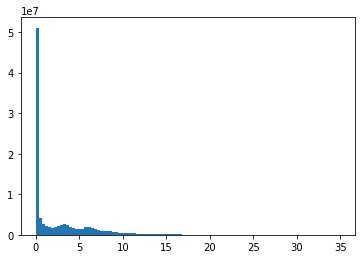

In [15]:
plt.hist(arr[arr>=0], bins=100);

In [14]:
np.quantile(arr, 0.999)

25.101731953291043

## Try the whole bbox ##

Here we will try the entire Santa Monica bbox at once.  Also I will try 0.5m resolution for the output.

In [19]:
# bbox of Santa Monica
xmin = -118.51765140181836
ymin = 33.995146776023624
xmax = -118.44351271585195
ymax = 34.050617079693275
sm_bbox = ([xmin, xmax], [ymin, ymax])

In [ ]:
pipeline = make_pipe(sm_bbox, f'{tmp}/full_SM_chm.tif', srs='EPSG:3857', threads=ncores, resolution=0.5)
count = pipeline.execute()